In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import re
import h5py
from six.moves import range

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline

In [2]:
import sys
sys.path.append('/Users/perdue/Documents/MINERvA/AI/ANNMINERvA/mnvtf')
print(sys.path)

from reader_text import MnvCategoricalTextReader

['', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python27.zip', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/plat-darwin', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/plat-mac', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/lib-tk', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/lib-old', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/lib-dynload', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/cycler-0.10.0-py2.7.egg', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/mccabe-0.6.1-py2.7.egg', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/IPython/extensions', '/Users/perdue/.ipython', '/Users/perdue/Documents/MINERvA/AI/ANNMINERvA/mnvtf']


In [3]:
def make_plots_raw(arr, plot_type, colormap='Reds'):
    """
    plots and text for confusion matrices
    """
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(1, 2)

    def make_title_string(title, logscale):
        title = r'Log$_{10}$ ' + title if logscale else title
        return title
    
    def make_subplot(ax, show_arr, colormap, title):
        im = ax.imshow(show_arr, cmap=plt.get_cmap(colormap), interpolation='nearest', origin='lower')
        cbar = plt.colorbar(im, fraction=0.04)
        plt.title(title)
        plt.xlabel('Softmax probabilties')
        plt.ylabel('Predicted segment')
        
    # linear plots
    ax = plt.subplot(gs[0])
    show_arr = arr
    make_subplot(ax, show_arr, colormap, make_title_string('Probabilities', False))

    # log plots
    ax = plt.subplot(gs[1])
    show_arr = np.log10(arr * 100.0)
    make_subplot(ax, show_arr, colormap, make_title_string('Probabilities', True))
    
    fig.savefig('reco_probabilities_{}.pdf'.format(plot_type), bbox_inches='tight')

In [4]:
def make_single_scatters_by_target(arr, plot_type, n_classes=173):
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(2, 4)
    
    idcs = np.arange(n_classes)    
    ids = zip(range(7), [0, 9, 18, 27, 44, 49, n_classes-1])
    
    for id in ids:
        ax = plt.subplot(gs[id[0]])
        tmparr = arr[:,id[1]]
        tmparr = tmparr / np.max(tmparr)
        plt.scatter(idcs, tmparr)
        #plt.ylim([-0.001, 0.009])
        
    fig.savefig('single_scatters_by_target_raw_{}.pdf'.format(plot_type), bbox_inches='tight')

In [19]:
def make_pred_z_dist(arr, n_classes=173):
    fig = plt.figure(figsize=(16, 8))
    plt.scatter(np.arange(n_classes), arr)
    
    fig = plt.figure(figsize=(16, 16))
    gs = plt.GridSpec(2, 4)
    idcs = np.arange(n_classes)
    rngs = [slice(0,7), slice(6,12), slice(15,21), slice(24,30), slice(41,47), slice(46,52), slice(n_classes-7,n_classes)]
    
    for i, rng in enumerate(rngs):
        ax = plt.subplot(gs[i])
        plt.scatter(idcs[rng], arr[rng])
        ax.set_ylim(ymin=0)

In [20]:
def make_scatters_by_target_same(arr1, arr2, plot_type, label1='MC', label2='Data', n_classes=173):
    idcs = np.arange(n_classes)
    ids = zip(range(7), [0, 9, 18, 27, 44, 49, n_classes-1])
    rngs = zip(
        [0, 9, 18, 27, 44, 49, n_classes-1],
        [slice(0,7), slice(6,12), slice(15,21), slice(24,30), slice(41,47), slice(46,52), slice(n_classes-7,n_classes)]
    )
    titles = ['upstream', 'target 1', 'target 2', 'target 3', 'target 4', 'target 5', 'upstream']
    leg_locs = [1] * 6 + [2]
            
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(2, 4)        
    for id in ids:
        ax = plt.subplot(gs[id[0]])
        tmparr1 = arr1[:,id[1]]
        tmparr2 = arr2[:,id[1]]
        plt.scatter(idcs, tmparr1, c='g', label=label1)
        plt.scatter(idcs, tmparr2, c='r', label=label2)
        plt.title(titles[id[0]])
        plt.xlabel('plane')
        plt.ylabel('softmax value')        
        plt.ylim([0.0, 1.0])
        plt.legend(loc=leg_locs[id[0]])
        
    fig.savefig('single_scatters_by_target_same_raw_{}.pdf'.format(plot_type), bbox_inches='tight')
    
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(2, 4)        
    for i, rng in enumerate(rngs):
        ax = plt.subplot(gs[i])
        tmparr1 = arr1[:,rng[0]]
        tmparr2 = arr2[:,rng[0]]
        plt.scatter(idcs[rng[1]], tmparr1[rng[1]], c='g', label=label1)
        plt.scatter(idcs[rng[1]], tmparr2[rng[1]], c='r', label=label2)
        plt.title(titles[id[0]])
        plt.xlabel('plane')
        plt.ylabel('softmax value')        
        plt.ylim([0.0, 1.0])
        plt.legend(loc=leg_locs[id[0]])
        
    fig.savefig('single_scatters_by_target_same_raw_tight_{}.pdf'.format(plot_type), bbox_inches='tight')

In [21]:
dt_dbn = '/Users/perdue/Documents/MINERvA/AI/prediction_dbs/tensorflow/201801/mnv_st_epsilon_predictionsME1BDATANX_model_20180223_def_chngdpad_planecodes_nclass173_trainME1EMC_validME1EMC_testME1EMC_optADAM_batchsz1024_nodoBatchNorm_tev.txt.gz'
mc_dbn = '/Users/perdue/Documents/MINERvA/AI/prediction_dbs/tensorflow/201801/mnv_st_epsilon_predictionsME1BMCNX_model_20180223_def_chngdpad_planecodes_nclass173_trainME1EMC_validME1EMC_testME1EMC_optADAM_batchsz1024_nodoBatchNorm_tev.txt.gz'

In [22]:
dt_rdr = MnvCategoricalTextReader(dt_dbn)
mc_rdr = MnvCategoricalTextReader(mc_dbn)

In [23]:
n_classes = 173

In [24]:
results_mc = np.zeros((n_classes, n_classes))
results_data = np.zeros((n_classes, n_classes))

In [25]:
n_events = 20000

In [26]:
dl_mc = mc_rdr.read_data_generator()
dl_dt = dt_rdr.read_data_generator()

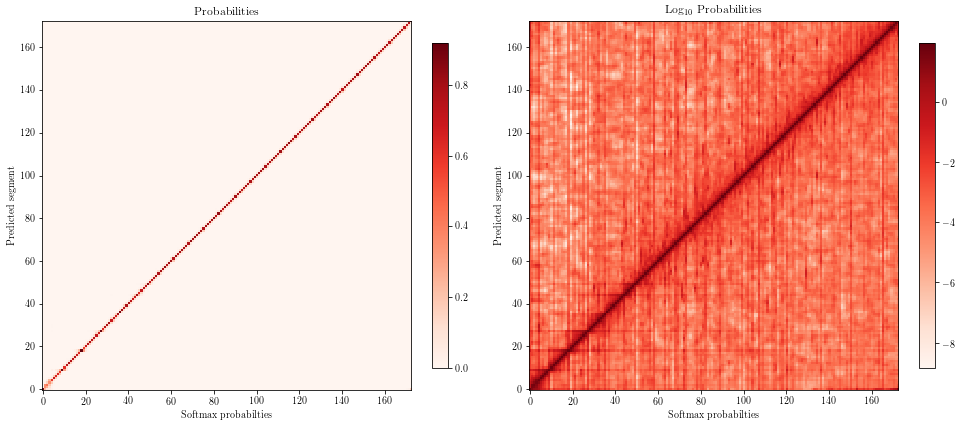

In [27]:
for i, d in enumerate(dl_mc):
    segment = d[1]
    results_mc[:,segment] += d[2][:]
    if i > n_events:
        break
    
n_pred_mc = np.zeros(n_classes)
for i in range(n_classes):
    s = np.sum(results_mc[:,i])
    n_pred_mc[i] = s
    results_mc[:,i] = results_mc[:,i] / s

make_plots_raw(results_mc, 'mc173')

/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()


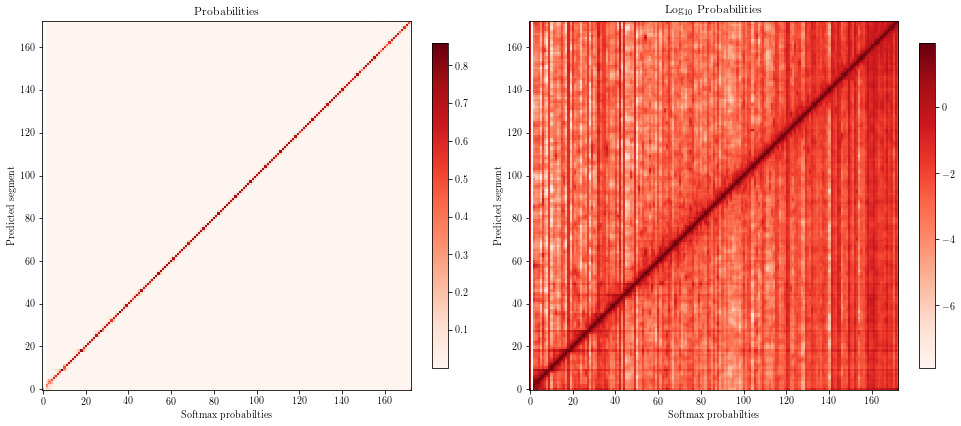

In [28]:
for i, d in enumerate(dl_dt):
    segment = d[1]
    results_data[:,segment] += d[2][:]
    if i > n_events:
        break
        
n_pred_dt = np.zeros(n_classes)
for i in range(n_classes):
    s = np.sum(results_data[:,i])
    n_pred_dt[i] = s
    results_data[:,i] = results_data[:,i] / s

make_plots_raw(results_data, 'data173')

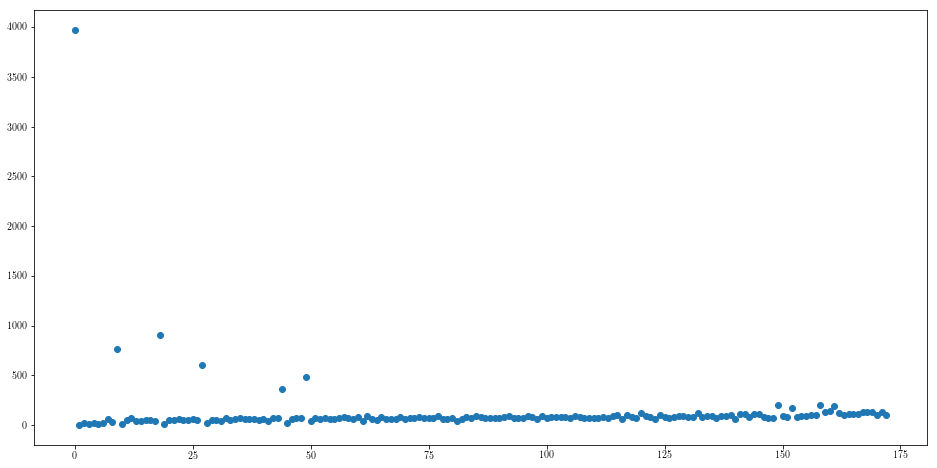

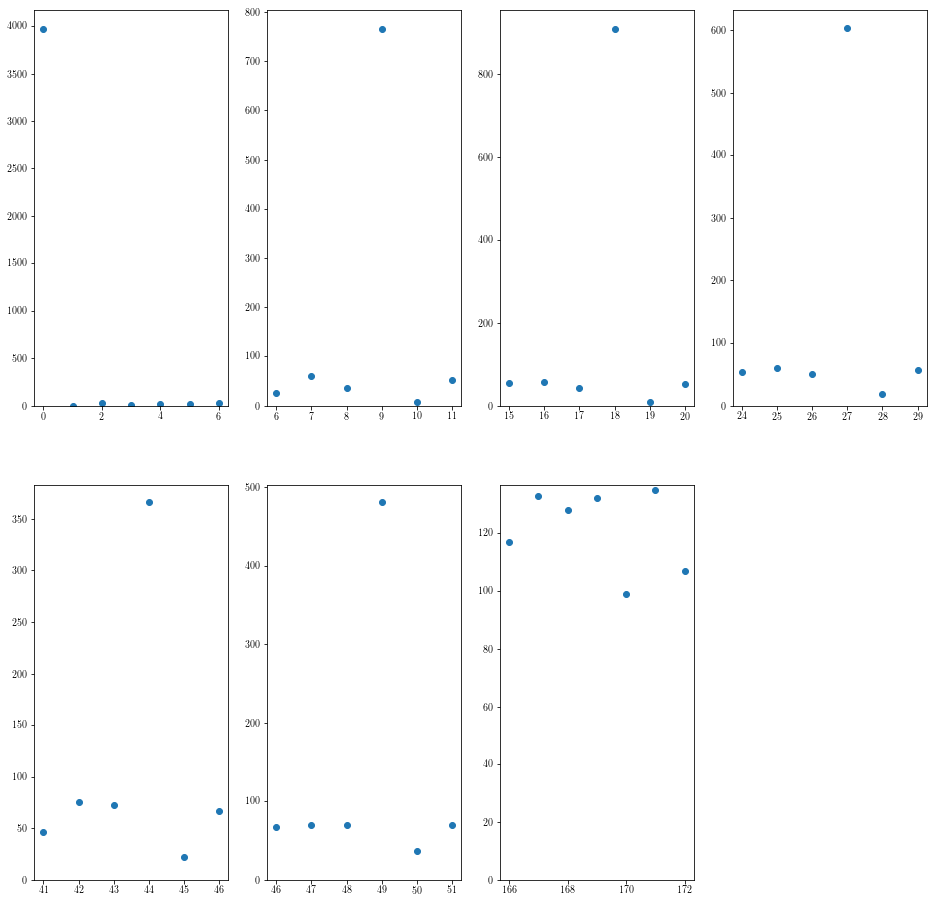

In [29]:
#plt.scatter(np.arange(n_classes), n_pred_dt)
make_pred_z_dist(n_pred_dt)

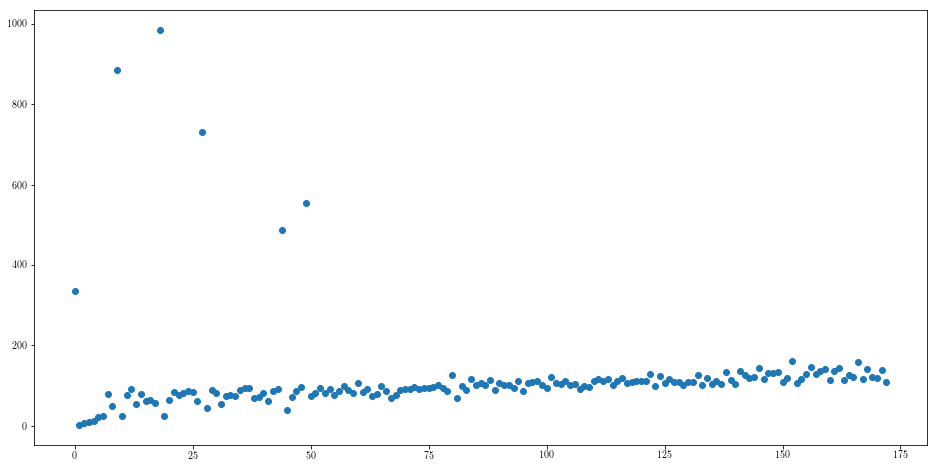

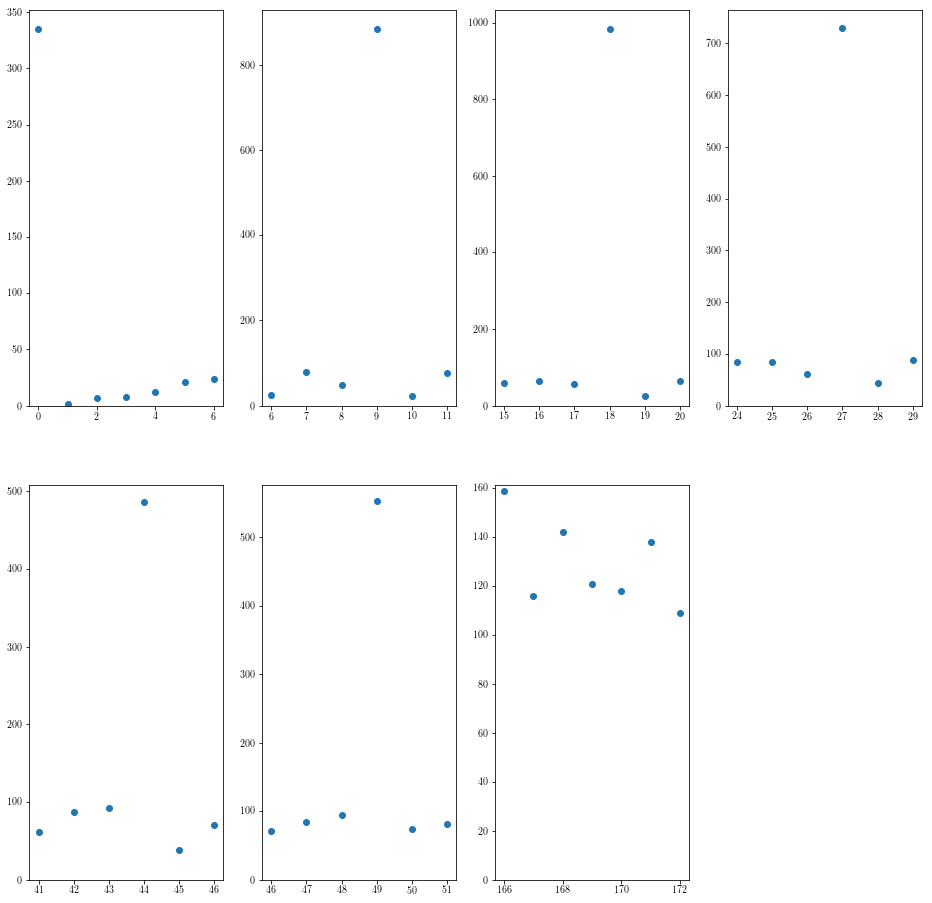

In [30]:
#plt.scatter(np.arange(n_classes), n_pred_mc)
make_pred_z_dist(n_pred_mc)

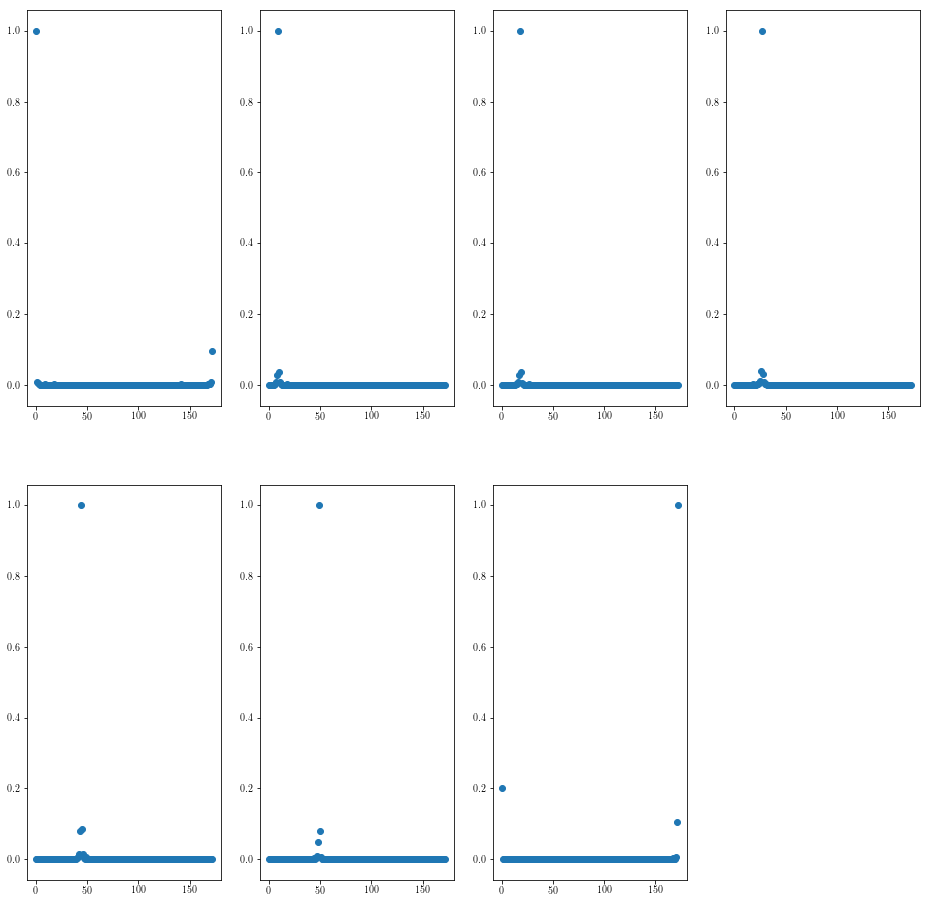

In [31]:
make_single_scatters_by_target(results_mc, 'mc173')

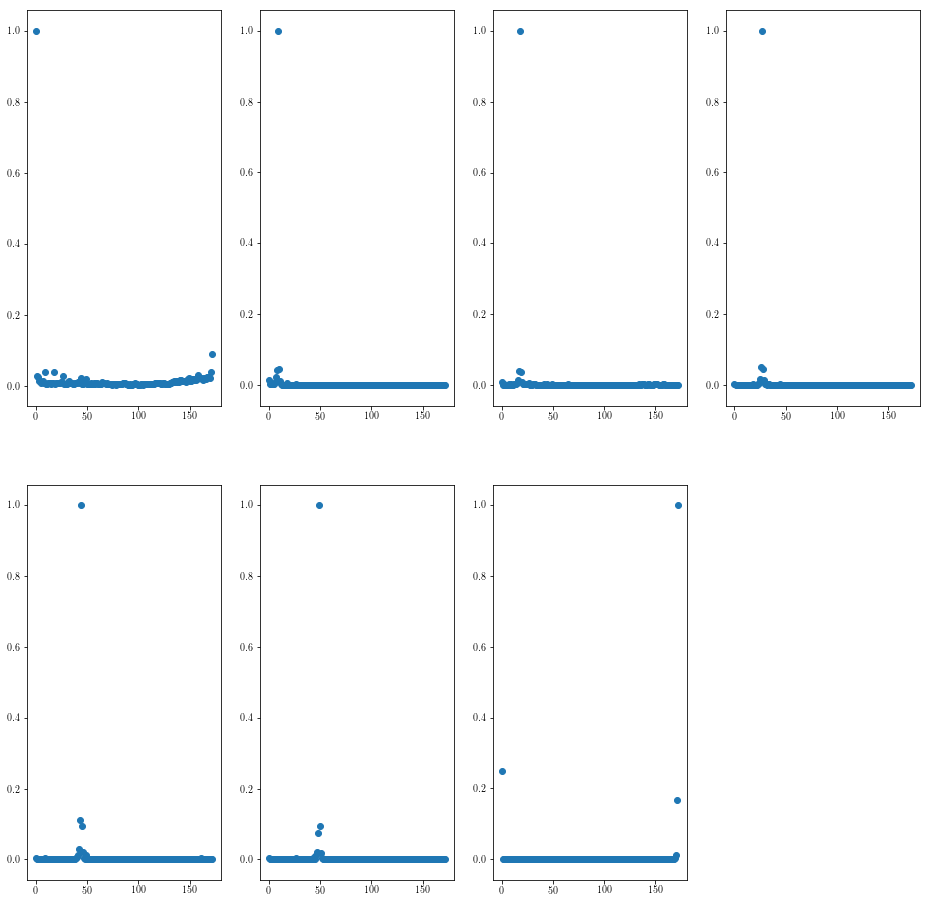

In [32]:
make_single_scatters_by_target(results_data, 'data173')

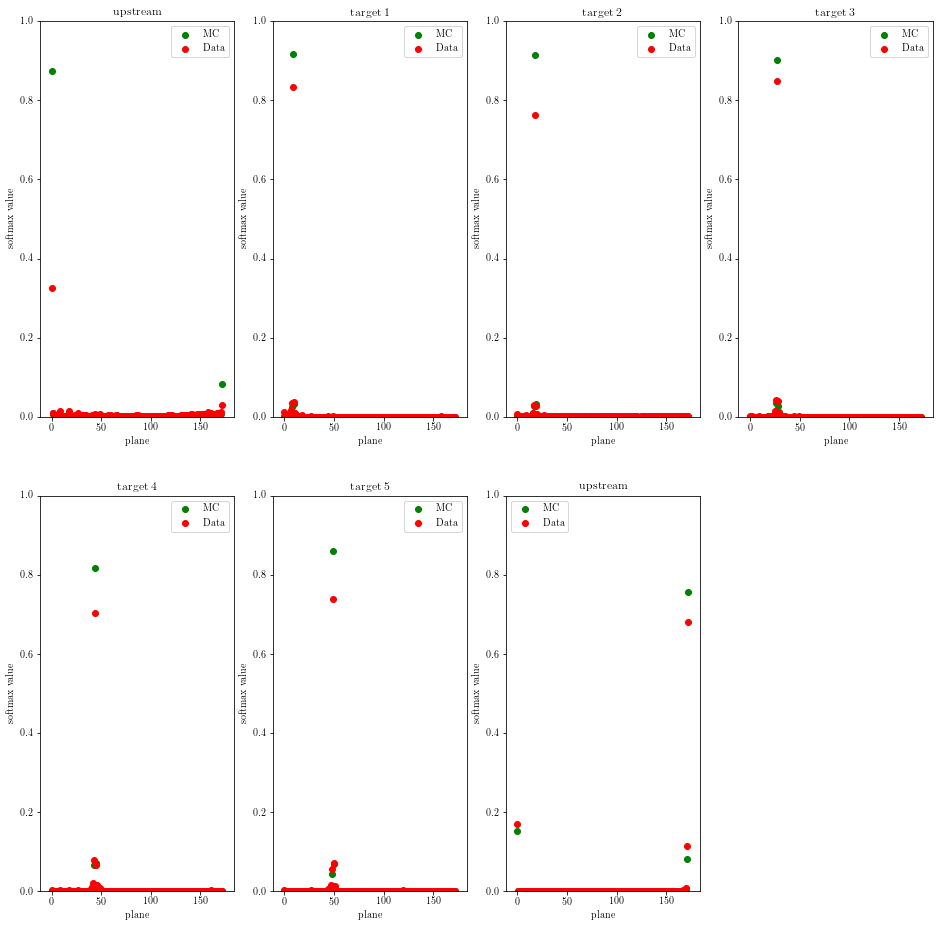

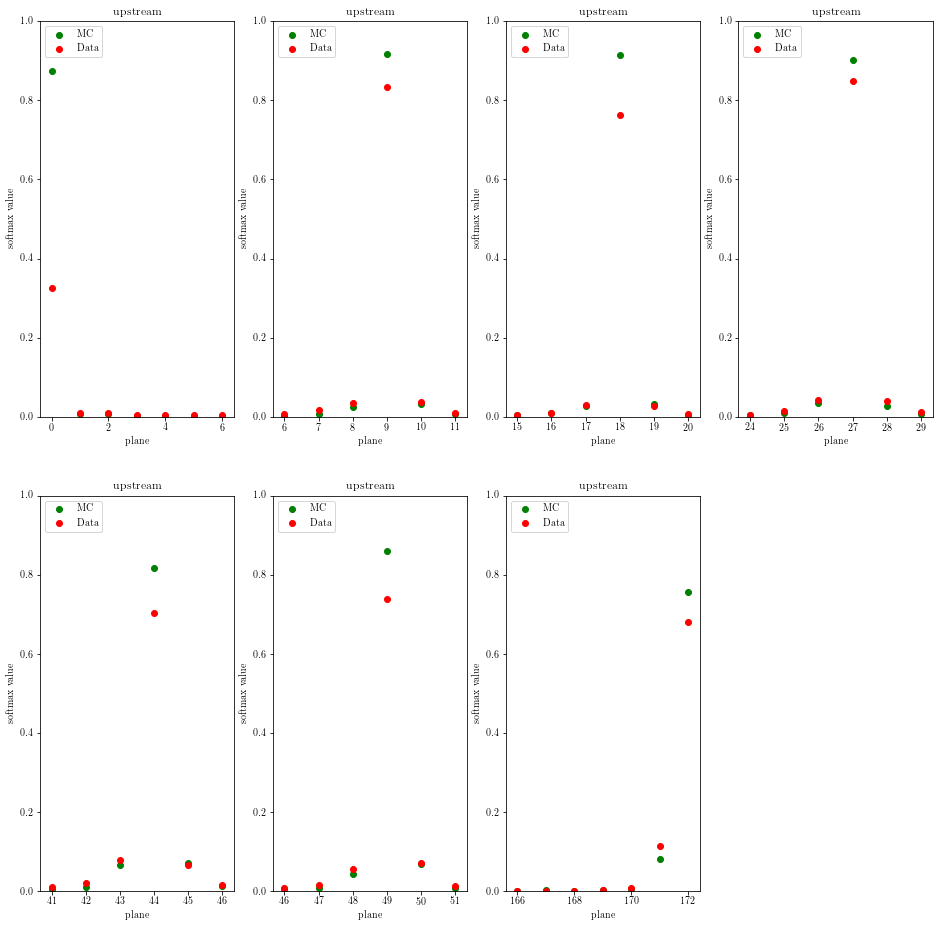

In [33]:
make_scatters_by_target_same(results_mc, results_data, 'TF173')